# Model Creation - Titanic Dataset

## Cameron Swanson

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
titanic_df = pd.read_csv('../Data/titanic.csv')
titanic_df.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


## Splitting Data - 80/20 Ratio

When splitting our data here, we'll stick to the "80/20" rule of thumb for now.  The random state is set in order to ensure reproducibility.  We'll also drop our __Name__ variable for the time being -- there are plenty of interesting way to use it in feature engineering, but we'll attempt this when trying to improve our model later.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(titanic_df.drop(['Name', 'Survived'], axis=1), 
                                                    titanic_df['Survived'], 
                                                    test_size = 0.2,
                                                    random_state = 123)

## Basic Feature Engineering

For our feature engineering, we'll make two significant changes to our data.  First, we'll __one-hot encode our Sex variable__ -- this will allow Sex to be represented with numerical data, but also avoids any implication of order between male and female passengers (this would be a problem if we simply converted "male" and "female" to 0 and 1).

Next, we'll __condense Siblings/Spouses and Parents/Children__ in order to create __Family Aboard__, which is equal to the sum of both columns.

In [4]:
# One-hot encoding "Sex" variable, combining siblings/spouses & parents/children variables

X_train = pd.get_dummies(X_train, prefix = ['Sex'], columns = ['Sex'])
X_train['Family Aboard'] = X_train['Siblings/Spouses Aboard'] + X_train['Parents/Children Aboard']
X_train.head()

,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male,Family Aboard
833,3,20.0,0,0,8.0500,0,1,0
97,2,34.0,0,1,23.0000,1,0,1
711,2,52.0,0,0,13.0000,0,1,0
43,3,19.0,0,0,7.8792,1,0,0
585,3,22.0,0,0,8.0500,0,1,0


In [5]:
X_test = pd.get_dummies(X_test, prefix = ['Sex'], columns = ['Sex'])
X_test['Family Aboard'] = X_test['Siblings/Spouses Aboard'] + X_test['Parents/Children Aboard']
X_test.head()

,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male,Family Aboard
580,1,36.0,0,0,40.1250,0,1,0
814,3,43.0,0,0,6.4500,0,1,0
147,2,36.5,0,2,26.0000,0,1,2
134,2,23.0,0,0,15.0458,0,1,0
633,3,32.0,0,0,7.9250,0,1,0


## Normalize - Min/Max Scaling

Next, we'll __normalize our training and test sets__ by __scaling our data__ such that all variables are __bound between 0 and 1.__

In [6]:
scaler = MinMaxScaler()
features = ['Pclass','Age','Siblings/Spouses Aboard','Parents/Children Aboard','Fare','Sex_female','Sex_male','Family Aboard']

X_train[features] = scaler.fit_transform(X_train[features])
X_train.head()

,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male,Family Aboard
833,1.0,0.242902,0.0,0.000000,0.015713,0.0,1.0,0.0
97,0.5,0.419558,0.0,0.166667,0.044893,1.0,0.0,0.1
711,0.5,0.646688,0.0,0.000000,0.025374,0.0,1.0,0.0
43,1.0,0.230284,0.0,0.000000,0.015379,1.0,0.0,0.0
585,1.0,0.268139,0.0,0.000000,0.015713,0.0,1.0,0.0


In [7]:
X_test[features] = scaler.transform(X_test[features])
X_test.head()

,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male,Family Aboard
580,0.0,0.444795,0.0,0.000000,0.078319,0.0,1.0,0.0
814,1.0,0.533123,0.0,0.000000,0.012590,0.0,1.0,0.0
147,0.5,0.451104,0.0,0.333333,0.050749,0.0,1.0,0.2
134,0.5,0.280757,0.0,0.000000,0.029367,0.0,1.0,0.0
633,1.0,0.394322,0.0,0.000000,0.015469,0.0,1.0,0.0


Finally, we just need to __drop__ our features that are now redundant -- that is, __Siblings/Spouses and Parents/Children__, since we've created the __Family Aboard__ variable.

In [8]:
# Drop the now-redundant features
X_train = X_train.drop(['Siblings/Spouses Aboard','Parents/Children Aboard'], axis=1)
X_test = X_test.drop(['Siblings/Spouses Aboard','Parents/Children Aboard'], axis=1)

## KNN Algorithm

Now it's time to __implement our algorithm__ to make predictions.  For our first attempt, we'll use a __k-nearest-neighbors classifier.__  To find our best value for $k$, we'll run our algorithm for a __range of $k$-values__, and find the one that gives us the __best accuracy score.__

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# For k = 1-80, predict on test set, and  
k_range = list(range(1,81))
acc_list = []
for i in k_range:
    knn = KNeighborsClassifier(n_neighbors = i).fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    acc_list.append(accuracy)
print("Best accuracy at k =", np.argmax(acc_list) + 1, "with accuracy of", max(acc_list))

Best accuracy at k = 6 with accuracy of 0.8314606741573034


For $k = 1 - 80$, we obtain our best accuracy score when __$k = 6$__, which gives us an accuracy score of __83.15%__.

# Plot of Accuracy Score vs. K

Finally, we'll create a plot of __accuracy score vs. $k$__ to see how our accuracy is affected when using different $k$-values.

Text(0.5, 1.0, 'Accuracy Score vs. K, K-Nearest Neighbors')

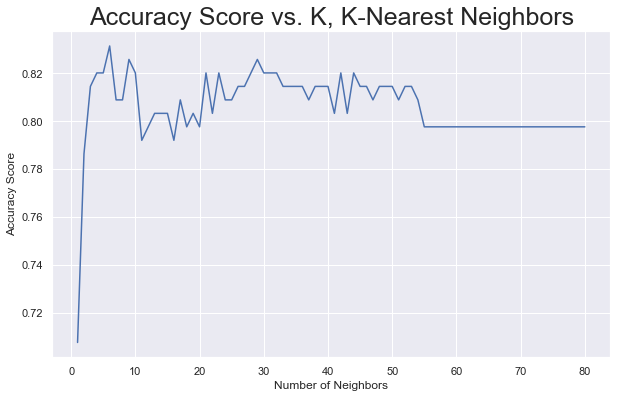

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize': (10,6)})
sns.set_style('darkgrid')
k_plot = sns.lineplot(k_range, acc_list)
k_plot.set(xlabel = 'Number of Neighbors', ylabel = 'Accuracy Score')
plt.title('Accuracy Score vs. K, K-Nearest Neighbors', fontdict = {'fontsize': 25})

By our above plot, we can observe our __maximum accuracy score__ at $k=6$, and we also see that __increasing $k$__ begins to have no further effects on our model at around __$k=55$.__